# CNN Cancer Detection Kaggle Mini Project

**DTSA-5511 Week 3 Project**

**Genesis Zhong**

https://github.com/genesischung/5511_cancer_detection

## Introduction

This is a Kaggle competition with an objective of identifying metastatic cancer tissue in pathology scan images. (https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview)

The data set used for this project is originally from the PatchCamelyon (PCam) benchmark, but now without any dupliacation in the data set.

## Setup

Before running this project, make sure that tensorflow is installed in the conda environment. Also make sure I have the software required to use GPU acceleration.

In [1]:
!conda activate tf
!nvidia-smi

usage: conda [-h] [--no-plugins] [-V] COMMAND ...
conda: error: argument COMMAND: invalid choice: 'activate' (choose from 'clean', 'compare', 'config', 'create', 'info', 'init', 'install', 'list', 'notices', 'package', 'remove', 'uninstall', 'rename', 'run', 'search', 'update', 'upgrade', 'doctor', 'env')
Fri Aug 11 18:52:21 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.98.01              Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090 

In [2]:
import os
# suppress tensorflow INFO messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import cv2
import os

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input, Rescaling
from tensorflow.keras.layers import Activation, BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2023-08-11 18:52:22.405921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
tf.__version__

'2.13.0'

In [5]:
train_labels = pd.read_csv('train_labels.csv')
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [6]:
train_labels['filepath'] =  'train/' + train_labels['id'] + '.tif'
train_labels = train_labels.astype({'filepath':'string'})
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        220025 non-null  object
 1   label     220025 non-null  int64 
 2   filepath  220025 non-null  string
dtypes: int64(1), object(1), string(1)
memory usage: 5.0+ MB


As shown in the info above, our training data contains 220025 images. Since the data set is rather large, we can use 10% of the data as the validation set.

In [7]:
df_train, df_valid = train_test_split(train_labels, test_size=0.1)

In [8]:
print(df_train.shape, df_valid.shape)

(198022, 3) (22003, 3)


## Exploratory Data Analysis

Below I plotted the number of images for each label in the entire data set. Although the distribution of label is not balanced, there is still a good number of `label=1` in the data set, so it should not be a problem when training models.

[Text(0.5, 1.0, 'Number of Images for Each Label')]

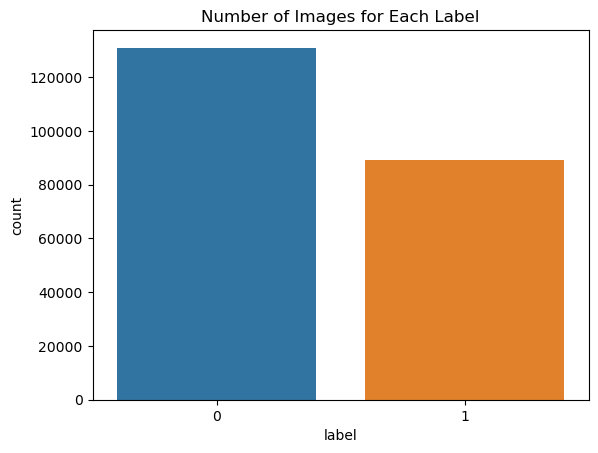

In [9]:
sns.countplot(data=train_labels, x='label').set(title="Number of Images for Each Label")

Next we try to verify the size of the image. The image is indeed 96 x 96 x 3.

In [10]:
for filepath in train_labels.sample(1)['filepath']:
    image = cv2.imread(filepath)
    h, w, c  = image.shape
    print("Image Resolution: {} x {}".format(w, h))
    print("Image Channel: {}".format(c))

Image Resolution: 96 x 96
Image Channel: 3


Next, let's check out some images!

Below I plotted 16 sample images for label = 0 (cancer-free) and 16 sample images for label = 1 (cancerous). I also added a 32 x 32 box to highlight the area we are concerned about.

Personally, I wasn't able to tell the difference, as I do not have a background in medical science. But hopefully the neural network will pick on the information and performs well at the task.

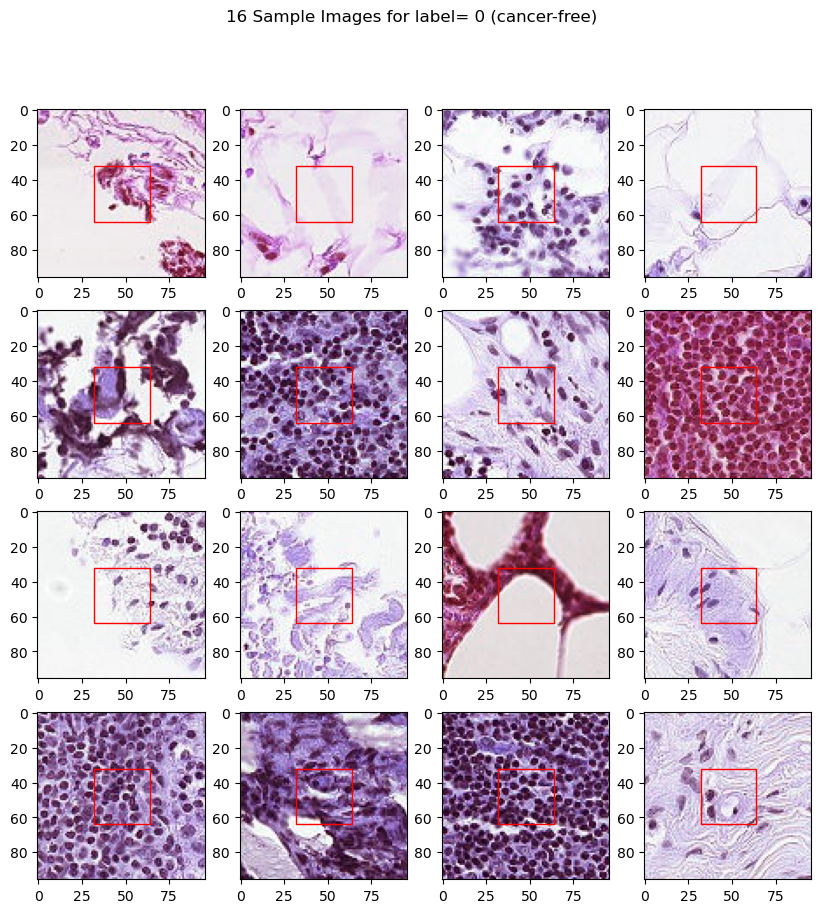

In [11]:
plt.figure(figsize=(10, 10))
plt.suptitle("16 Sample Images for label= 0 (cancer-free)")
for idx, filepath in enumerate(train_labels[train_labels.label == 0].sample(16, random_state=2023)['filepath']):
    ax = plt.subplot(4, 4, idx+1)
    image = cv2.imread(filepath)
    plt.imshow(image)
    ax.add_patch(Rectangle((32, 32), 32, 32, facecolor='none', edgecolor='red'))

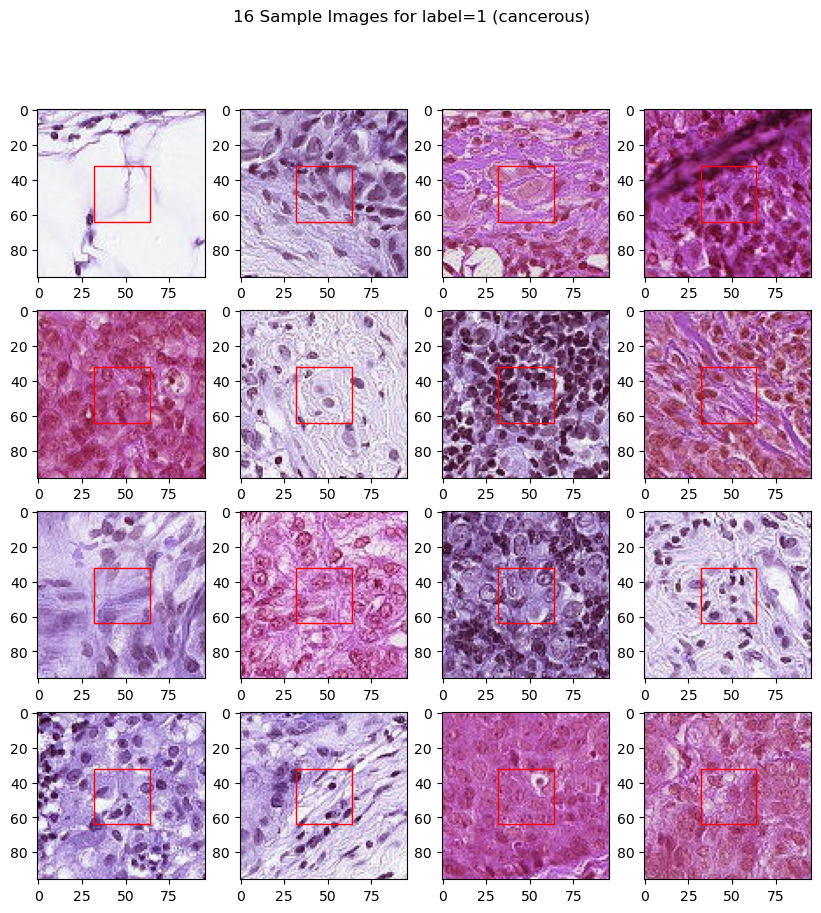

In [12]:
plt.figure(figsize=(10, 10))
plt.suptitle("16 Sample Images for label=1 (cancerous)")
for idx, filepath in enumerate(train_labels[train_labels.label == 1].sample(16, random_state=2023)['filepath']):
    ax = plt.subplot(4, 4, idx+1)
    image = cv2.imread(filepath)
    plt.imshow(image)
    ax.add_patch(Rectangle((32, 32), 32, 32, facecolor='none', edgecolor='red'))

Since `ImageDataGenerator` is deprecated, and the recommended `image_dataset_from_directory` method does not support TIFF images, I will manually load the images into a tf.data.Dataset.

In [13]:
def load_images(df, n):
    """
    load the images in df
    and return a tf.data.Dataset
    """
    # check n
    if n is None:
        n = df.shape[0]
    if n < 1 or n > df.shape[0]:
        print("n out of bound")
        return
    # prepare data structure
    X = np.zeros([n, 96, 96, 3], dtype=np.uint8)
    y = df['label'].values[0:n]
    # load the images
    for i in tqdm(range(n), desc='loading images'):
        X[i] = cv2.imread(df['filepath'].iloc[i])
    # return tf.data.Dataset
    return tf.data.Dataset.from_tensor_slices((X, y))
    

In [14]:
train_dataset = load_images(df_train, None)

loading images:   0%|          | 0/198022 [00:00<?, ?it/s]

2023-08-11 18:52:39.709172: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5474912256 exceeds 10% of free system memory.
2023-08-11 18:52:43.761805: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5474912256 exceeds 10% of free system memory.


In [15]:
valid_dataset = load_images(df_valid, None)

loading images:   0%|          | 0/22003 [00:00<?, ?it/s]

## Modeling

For my first model, I take inspiration from the LeNet-5 architecture, hoping that it will be simple yet effective. The table below outlines the design of the architecture.

|        | Layer       | Feature Map | Size  | Kernel Size | Activation |
|--------|-------------|-------------|-------|-------------|------------|
| Input  | Image       | 3           | 96x96 | -           | -          |
| 1      | Rescaling   | 3           | 96x96 | -           | -          |
| 2      | Convolution | 32          | 96x96 | 3x3         | relu       |
| 3      | Max Pooling | 32          | 48x48 | 2x2         |            |
| 4      | Convolution | 64          | 48x48 | 3x3         | relu       |
| 5      | Max Pooling | 64          | 24x24 | 2x2         |            |
| 6      | FC          |             | 64    |             | relu       |
| 7      | FC          |             | 32    |             | relu       |
| Output | FC          |             | 1     |             | sigmoid    |

In [16]:
model1 = Sequential(
    [
        Input(shape=(96, 96, 3)),

        Rescaling(scale=1./255),

        # Conv layer 1. Input: 96x96x3, Output: 96x96x32
        Conv2D(32, (3, 3), padding="same"),
        Activation("relu"),
        # SubSampling 1. Input: 96x96x32. Output: 48x48x32
        MaxPooling2D((2, 2)),

        # Conv Layer 2. Input:48x48x32, Output:48x48x64
        Conv2D(64, (3, 3), padding="same"),
        Activation("relu"),
        #SubSampling 2. Input: 48x48x64, Output:24x24x64
        MaxPooling2D((2, 2)),

        Flatten(),
        # FC1. Output: 64
        Dense(64, activation="relu"),
        # FC2. Output:32
        Dense(32, activation="relu"),

        # Output: 0-1
        Dense(1, activation="sigmoid"),        
    ]
)

model1.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        #tf.keras.metrics.AUC(name='auc'), 
        tf.keras.metrics.BinaryAccuracy(),
    ]
)

In [27]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                        

In [18]:
model1_hist = model1.fit(
    train_dataset.batch(512), 
    validation_data=valid_dataset.batch(512),
    epochs=50,
    callbacks=[EarlyStopping(monitor='val_binary_accuracy', patience=6, restore_best_weights=True)]
)

2023-08-11 18:52:46.208932: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5474912256 exceeds 10% of free system memory.


Epoch 1/50
387/387 [==============================] - 18s 33ms/step - loss: 0.4855 - binary_accuracy: 0.7707 - val_loss: 0.4419 - val_binary_accuracy: 0.8011
Epoch 2/50
387/387 [==============================] - 12s 31ms/step - loss: 0.4383 - binary_accuracy: 0.8023 - val_loss: 0.4163 - val_binary_accuracy: 0.8150
Epoch 3/50
387/387 [==============================] - 12s 30ms/step - loss: 0.4187 - binary_accuracy: 0.8128 - val_loss: 0.4207 - val_binary_accuracy: 0.8107
Epoch 4/50
387/387 [==============================] - 13s 32ms/step - loss: 0.4078 - binary_accuracy: 0.8180 - val_loss: 0.4156 - val_binary_accuracy: 0.8140
Epoch 5/50
387/387 [==============================] - 13s 33ms/step - loss: 0.3986 - binary_accuracy: 0.8226 - val_loss: 0.4028 - val_binary_accuracy: 0.8206
Epoch 6/50
387/387 [==============================] - 12s 31ms/step - loss: 0.3898 - binary_accuracy: 0.8274 - val_loss: 0.3988 - val_binary_accuracy: 0.8222
Epoch 7/50
387/387 [==============================] 

In [52]:
def plot_graphs(history, metric, title):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.title(title)

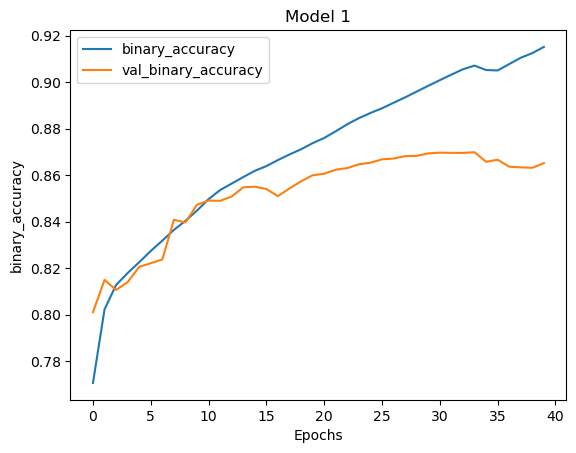

In [53]:
plot_graphs(model1_hist, 'binary_accuracy', 'Model 1 Accuracy')

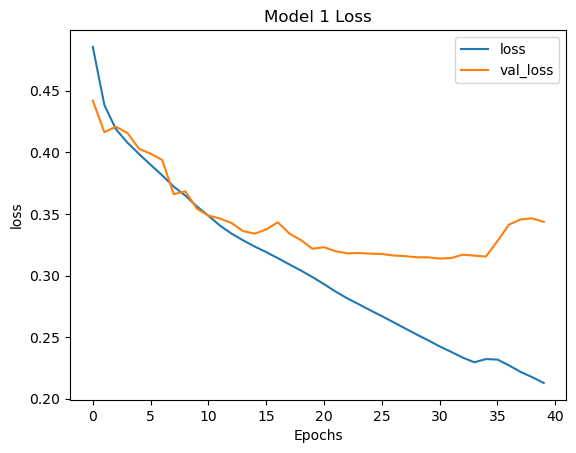

In [79]:
plot_graphs(model1_hist, 'loss', 'Model 1 Loss')

I used Early Stopping to stop overfitting the model, and the model stopped after 40 epochs. It also restores the weights at epoch 34, which seems to be getting the best results. The validation accuracy we got is around 0.86 to 0.87, which is not bad for a rather simple architecture.

## Hyperparameter Tuning

For hyperparameter tuning, I think the one hyperparameter I should first explore is optimizer. Depending on the choice of optimizer, the optimal learning rate may be different.

So below I attempted the same model as above with three different optimizers: Adam, SGD. and RMSProp.

In [37]:
def hyperparameter_tuning():
    results = list()
    for opt in ['adam', 'sgd', 'rmsprop']:
        cnn = Sequential(
                [
                Input(shape=(96, 96, 3)),

                Rescaling(scale=1./255),

                # Conv layer 1. Input: 96x96x3, Output: 96x96x32
                Conv2D(32, (3, 3), padding="same"),
                Activation("relu"),
                # SubSampling 1. Input: 96x96x32. Output: 48x48x32
                MaxPooling2D((2, 2)),

                # Conv Layer 2. Input:48x48x32, Output:48x48x64
                Conv2D(64, (3, 3), padding="same"),
                Activation("relu"),
                #SubSampling 2. Input: 48x48x64, Output:24x24x64
                MaxPooling2D((2, 2)),

                Flatten(),
                # FC1. Output: 64
                Dense(64, activation="relu"),
                # FC2. Output:32
                Dense(32, activation="relu"),

                # Output: 0-1
                Dense(1, activation="sigmoid"),        
                ]
            )
        cnn.compile(
                optimizer=opt,
                loss='binary_crossentropy',
                metrics=[
                    tf.keras.metrics.BinaryAccuracy(),
                ]
            )

        hist = cnn.fit(
                train_dataset.batch(512), 
                validation_data=valid_dataset.batch(512),
                epochs=50,
                callbacks=[EarlyStopping(monitor='val_binary_accuracy', patience=6, restore_best_weights=True)]
                )
        results.append((opt, hist))

    return results
            
            

In [38]:
tuning_results = hyperparameter_tuning()

Epoch 1/50
387/387 [==============================] - 14s 31ms/step - loss: 0.4828 - binary_accuracy: 0.7758 - val_loss: 0.4457 - val_binary_accuracy: 0.7992
Epoch 2/50
387/387 [==============================] - 12s 31ms/step - loss: 0.4090 - binary_accuracy: 0.8171 - val_loss: 0.3731 - val_binary_accuracy: 0.8377
Epoch 3/50
387/387 [==============================] - 12s 31ms/step - loss: 0.3704 - binary_accuracy: 0.8370 - val_loss: 0.3535 - val_binary_accuracy: 0.8482
Epoch 4/50
387/387 [==============================] - 12s 31ms/step - loss: 0.3434 - binary_accuracy: 0.8503 - val_loss: 0.3468 - val_binary_accuracy: 0.8478
Epoch 5/50
387/387 [==============================] - 11s 29ms/step - loss: 0.3181 - binary_accuracy: 0.8622 - val_loss: 0.3180 - val_binary_accuracy: 0.8619
Epoch 6/50
387/387 [==============================] - 12s 32ms/step - loss: 0.2932 - binary_accuracy: 0.8750 - val_loss: 0.2966 - val_binary_accuracy: 0.8738
Epoch 7/50
387/387 [==============================] 

In [39]:
tuning_results

[('adam', <keras.src.callbacks.History at 0x7f45b9db9510>),
 ('sgd', <keras.src.callbacks.History at 0x7f45ba3e7b80>),
 ('rmsprop', <keras.src.callbacks.History at 0x7f45b9a0b490>)]

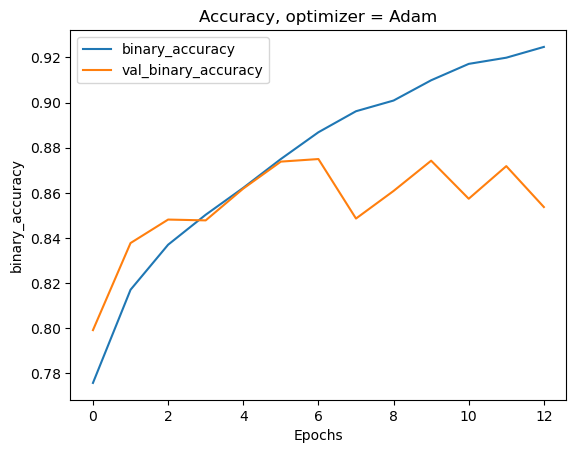

In [82]:
plot_graphs(tuning_results[0][1], 'binary_accuracy', 'Accuracy, optimizer = Adam')

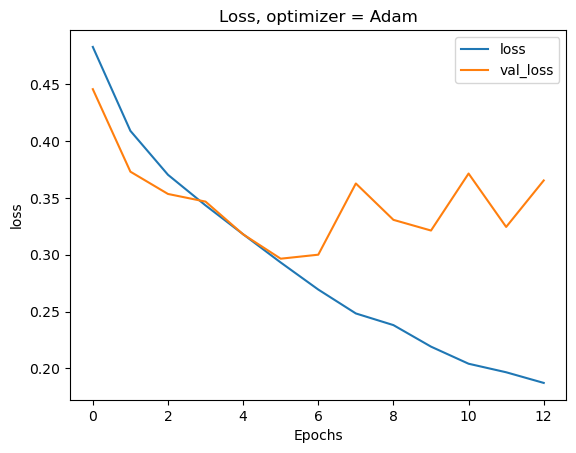

In [83]:
plot_graphs(tuning_results[0][1], 'loss', 'Loss, optimizer = Adam')

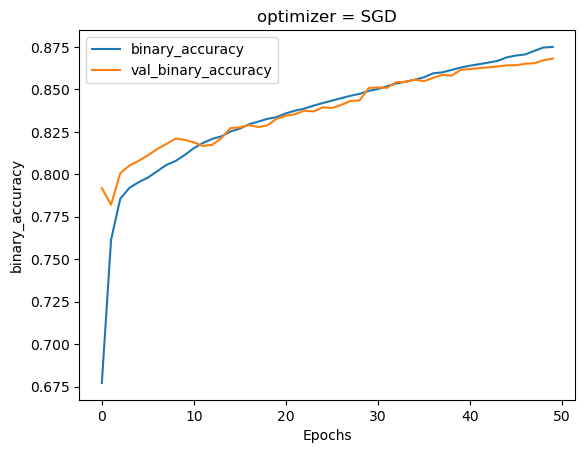

In [84]:
plot_graphs(tuning_results[1][1], 'binary_accuracy', 'optimizer = SGD')

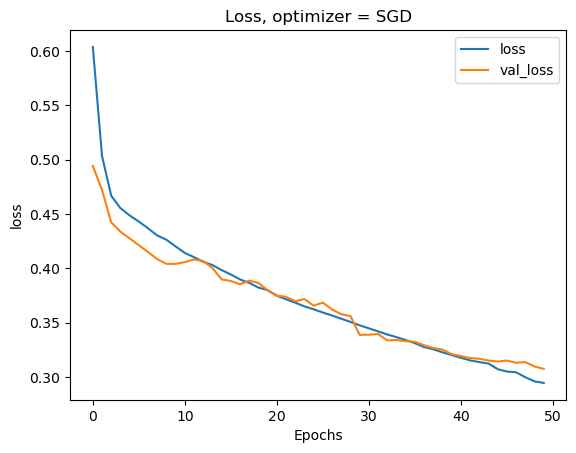

In [85]:
plot_graphs(tuning_results[1][1], 'loss', 'Loss, optimizer = SGD')

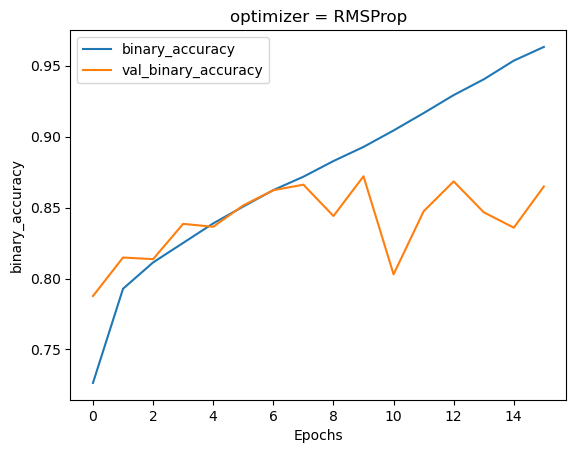

In [86]:
plot_graphs(tuning_results[2][1], 'binary_accuracy', 'optimizer = RMSProp')

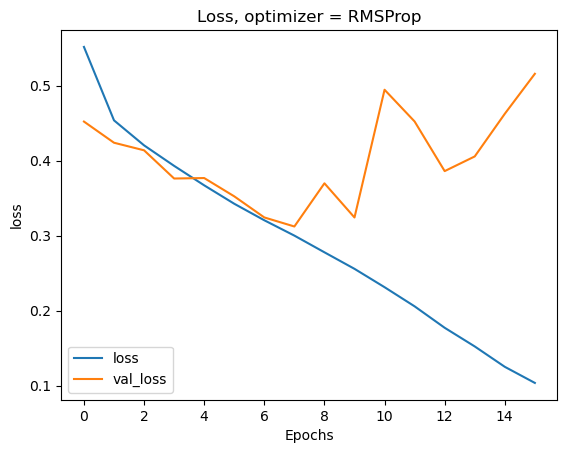

In [87]:
plot_graphs(tuning_results[2][1], 'loss', 'Loss, optimizer = RMSProp')

From the six plots above, we can first notice that the loss curve on the RMSProp model is a bit too stright, suggesting a low learning rate. We can also observe that the validation accuracy is only still improving for the SGD model, which has a good looking loss vs. epoch curve. In fact, the Adam and RMSProp model stopped training after around 10 epochs because the accuracy is not improving. 

With that said, SGD is still not the best option here. After 50 epochs, the validation accuracy on the SGD model is still around 0.85. Adam actually performs the best, with the validation accuracy approaching 0.88 after just 4 epochs. So we should be using Adam as our optimizer. Since Adam uses adaptive learning rates, we don't have to worry about learning rates anymore. However, we should consider adding a decay since it does seem to converge rather quickly.

## Second Model

For my second model, I wanted to try something more sophisticated with more layers. So my design is highly influenced by the architecture of VGGNet Config B (VGG-13).

From both the lecture and online resources, VGGNet is one of the more popular CNN architecture for image classification. Furthermore, it seems more straightforward to implement comparing to some other architecture such as ResNet and InceptionV4.

The model I implemented essentially contains 5 blocks, each containing 2 convolutional layers and a max pooling layer. The detailed architecture is outlined in the table below.

|             | Layer       | Feature Map | Size  | Kernel Size | Activation |
|-------------|-------------|-------------|-------|-------------|------------|
| Input       | Image       | 3           | 96x96 | -           | -          |
| **Block 1** |             |             |       |             |            |
| 1           | Rescaling   | 3           | 96x96 | -           | -          |
| 2           | Convolution | 64          | 96x96 | 3x3         | relu       |
| 3           | Convolution | 64          | 96x96 | 3x3         | relu       |
| 4           | Max Pooling | 64          | 48x48 | 2x2         |            |
| **Block 2** |             |             |       |             |            |
| 5           | Convolution | 128         | 48x48 | 3x3         | relu       |
| 6           | Convolution | 128         | 48x48 | 3x3         | relu       |
| 7           | Max Pooling | 128         | 24x24 | 2x2         |            |
| **Block 3** |             |             |       |             |            |
| 8           | Convolution | 256         | 24x24 | 3x3         | relu       |
| 9           | Convolution | 256         | 24x24 | 3x3         | relu       |
| 10          | Max Pooling | 256         | 12x12 | 2x2         |            |
| **Block 4** |             |             |       |             |            |
| 11          | Convolution | 512         | 12x12 | 3x3         | relu       |
| 12          | Convolution | 512         | 12x12 | 3x3         | relu       |
| 13          | Max Pooling | 512         | 6x6   | 2x2         |            |
| **Block 5** |             |             |       |             |            |
| 14          | Convolution | 512         | 6x6   | 3x3         | relu       |
| 15          | Convolution | 512         | 6x6   | 3x3         | relu       |
| 16          | Max Pooling | 512         | 3x3   | 2x2         |            |
|    **FC**   |             |             |       |             |            |
| 17          | FC          |             | 4096  |             | relu       |
| 18          | FC          |             | 4096  |             | relu       |
| Output      | FC          |             | 1     |             | sigmoid    |

In [20]:
model2 = Sequential(
    [
        Input(shape=(96, 96, 3)),
        # Block 1
        Rescaling(scale=1./255),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Block 2
        Conv2D(128, (3,3), activation='relu', padding='same'),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        # Block 3
        Conv2D(256, (3,3), activation='relu', padding='same'),
        Conv2D(256, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        # Block 4
        Conv2D(512, (3,3), activation='relu', padding='same'),
        Conv2D(512, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),            

        # Block 5
        Conv2D(512, (3,3), activation='relu', padding='same'),
        Conv2D(512, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),     

        # FC
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(1, activation='sigmoid'),
    ]
)

model2.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        #tf.keras.metrics.AUC(name='auc'), 
        tf.keras.metrics.BinaryAccuracy(),
    ]
)

In [77]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 128)       147584    
                                                      

In [21]:
model2_hist = model2.fit(
    train_dataset.batch(512), 
    validation_data=valid_dataset.batch(512),
    epochs=50,
    callbacks=[EarlyStopping(monitor='val_binary_accuracy', patience=6, restore_best_weights=True)]
)

2023-08-11 19:15:36.427020: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 5474912256 exceeds 10% of free system memory.


Epoch 1/50
387/387 [==============================] - 120s 275ms/step - loss: 0.4446 - binary_accuracy: 0.7929 - val_loss: 0.3826 - val_binary_accuracy: 0.8362
Epoch 2/50
387/387 [==============================] - 97s 250ms/step - loss: 0.3400 - binary_accuracy: 0.8525 - val_loss: 0.3201 - val_binary_accuracy: 0.8630
Epoch 3/50
387/387 [==============================] - 97s 251ms/step - loss: 0.2683 - binary_accuracy: 0.8884 - val_loss: 0.2615 - val_binary_accuracy: 0.8927
Epoch 4/50
387/387 [==============================] - 97s 251ms/step - loss: 0.2201 - binary_accuracy: 0.9133 - val_loss: 0.1916 - val_binary_accuracy: 0.9283
Epoch 5/50
387/387 [==============================] - 98s 253ms/step - loss: 0.1877 - binary_accuracy: 0.9283 - val_loss: 0.1771 - val_binary_accuracy: 0.9324
Epoch 6/50
387/387 [==============================] - 98s 253ms/step - loss: 0.1667 - binary_accuracy: 0.9375 - val_loss: 0.2160 - val_binary_accuracy: 0.9134
Epoch 7/50
387/387 [=========================

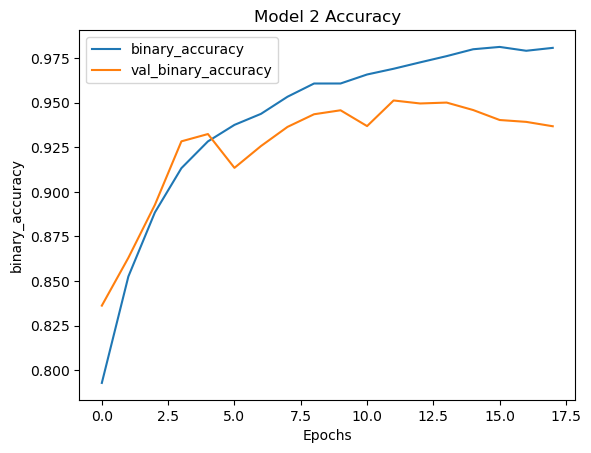

In [80]:
plot_graphs(model2_hist, 'binary_accuracy', 'Model 2 Accuracy')

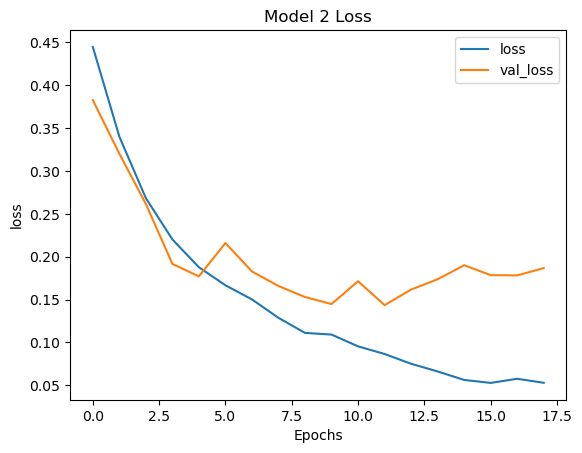

In [81]:
plot_graphs(model2_hist, 'loss', 'Model 2 Loss')

The model stopped training after 18 epochs, with the best weights obtained at epoch 12. The model was getting a validation accuracy of 0.95, which is quite impressive.

## Results on Test set

To really examine how well the two models are at predicting images with cancerous cells, we predict on the test images and make submissions to Kaggle.

In [58]:
submission = pd.read_csv('sample_submission.csv')
submission['filepath'] = 'test/' +sample_submission['id'] + '.tif'
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        57458 non-null  object
 1   label     57458 non-null  int64 
 2   filepath  57458 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [56]:
submission.shape[0]

57458

In [59]:
test_data = np.zeros([submission.shape[0], 96, 96, 3], dtype=np.uint8)
for i in tqdm(range(submission.shape[0])):
    test_data[i] = cv2.imread(submission['filepath'].iloc[i])
test_data.shape

  0%|          | 0/57458 [00:00<?, ?it/s]

(57458, 96, 96, 3)

In [60]:
yp_1 = model1.predict(test_data)

1796/1796 [==============================] - 3s 1ms/step


In [69]:
submission_1 = pd.DataFrame({
                            "id": np.array(submission['id']),
                            "label": yp_1.reshape(-1) })
submission_1

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.041299
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.830460
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.070622
3,2c35657e312966e9294eac6841726ff3a748febf,0.044878
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.051617
...,...,...
57453,061847314ded6f81e1cd670748bfa2003442c9c7,0.001696
57454,6f3977130212641fd5808210015a609c658dcbff,0.001766
57455,46935f247278539eca74b54d07d666efb528a753,0.016534
57456,a09bcae08a82120183352e0e869181b2911d3dc1,0.000381


In [71]:
submission_1.to_csv("submission_1.csv", index=False, header=True)

![model 1 results](result_1.png)

In [74]:
yp_2 = model2.predict(test_data)

1796/1796 [==============================] - 12s 7ms/step


In [75]:
submission_2 = pd.DataFrame({
                            "id": np.array(submission['id']),
                            "label": yp_2.reshape(-1) })
submission_2.to_csv("submission_2.csv", index=False, header=True)

![model 2 result](result_2.png)

| Model   | Validation Accuracy | Public Score | Private Score |
|---------|---------------------|--------------|------------|
| Model 1 | 0.869               | 0.8988       | 0.8698     |
| Model 2 | 0.951               | 0.9444       | 0.8958     |

## Discussion and Conclusion


This project really demonstrated how powerful CNN are at image classification. The simplistic Model 1 achieved a public score of 0.8988, and a private score of 0.8698 on Kaggle. The more complicated Model 2 achieved a public score of 0.9444, and a private score of 0.8958. 

Here are my takeaways:

- Both model perform relatively well for the short amount of time they are trained.
- Model 2 performs significantly better than Model 1. So designing a better architecture may be more beneficial than hyperparameter tuning.
- As I was getting much higher public score than private score, this tells me that I am somehow overfitting on the test set. This is a key area I need to work on in the future.
- Unlike machine learning models, each neural network takes a long time to train, which makes a grid search for hyperparameter very resource intensive. There has to be a better way.
- I have a decent GPU, which allows me to use large batch size in place of higher learning rate to speed up the training. However, I am not utilizing the processing power to the full advantage, as the model didn't take many epochs to train.


## Reference
- Lecun, Yann & Bottou, Leon & Bengio, Y. & Haffner, Patrick. (1998). Gradient-Based Learning Applied to Document Recognition. Proceedings of the IEEE. 86. 2278 - 2324. 10.1109/5.726791. 
- Simonyan, Karen & Zisserman, Andrew. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv 1409.1556. 
